In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check GPU (optional)
!nvidia-smi

Sat Mar 26 09:43:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torchsummary import summary

ROOT_PATH = '/content/drive/MyDrive/Colab/qmul/NN/projects/codes'
sys.path.append(ROOT_PATH)
from my_module import functions as myf
from my_module import make_dataset as mds
model_path = '/content/drive/MyDrive/Colab/qmul/NN/projects/model_para/'

In [ ]:
#get dataloader
train_dl = mds.get_dl(
    data='training', 
    bs=64, 
    shuffle=True, 
    transform=tt.Compose([tt.ToTensor(), tt.Normalize(0.5, 0.5)])
)
validation_dl = mds.get_dl(
    data='validation', 
    bs=64, 
    shuffle=False, 
    transform=tt.Compose([tt.ToTensor(), tt.Normalize(0.5, 0.5)])
)
dev = "cuda" if torch.cuda.is_available() else "cpu"

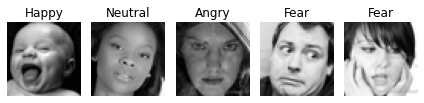

In [ ]:
#check some samples
dict_classes={
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprised',
    6: 'Neutral'
  }
fig, axes = plt.subplots(1, 5, tight_layout=True)
for i in range(5):
    img, label = train_dl.dataset[np.random.randint(0,10000)]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(dict_classes[label])


In [ ]:
#NN model
class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 9 * 9, 120)  # 9*9 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Base_CNN_dropout(nn.Module):
    def __init__(self):
        super(Base_CNN_dropout, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 9 * 9, 120)  # 9*9 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
model = Base_CNN().to(dev)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

Base_CNN_train_acc, Base_CNN_val_acc = myf.fit(
    model,
    loss_fn,
    optimizer,
    epochs,
    train_dl,
    validation_dl,
    print_loss=True
)
torch.save(model.state_dict(), model_path + 'Base_CNN.pth')

Epoch 1
loss: 1.784008  [ 6336/28709]
loss: 1.667920  [12736/28709]
loss: 1.675454  [19136/28709]
loss: 1.489247  [25536/28709]
Train accuracy: 31.5% 
Val accuracy  : 38.8%
-------------------------------
Epoch 2
loss: 1.426642  [ 6336/28709]
loss: 1.613281  [12736/28709]
loss: 1.593463  [19136/28709]
loss: 1.657770  [25536/28709]
Train accuracy: 38.9% 
Val accuracy  : 39.0%
-------------------------------
Epoch 3
loss: 1.563800  [ 6336/28709]
loss: 1.564054  [12736/28709]
loss: 1.533122  [19136/28709]
loss: 1.478476  [25536/28709]
Train accuracy: 42.6% 
Val accuracy  : 41.8%
-------------------------------
Epoch 4
loss: 1.419664  [ 6336/28709]
loss: 1.130907  [12736/28709]
loss: 1.657698  [19136/28709]
loss: 1.212172  [25536/28709]
Train accuracy: 45.2% 
Val accuracy  : 43.2%
-------------------------------
Epoch 5
loss: 1.405740  [ 6336/28709]
loss: 1.326995  [12736/28709]
loss: 1.434888  [19136/28709]
loss: 1.259945  [25536/28709]
Train accuracy: 47.4% 
Val accuracy  : 44.6%
-------

In [ ]:
model = Base_CNN().to(dev)
model.load_state_dict(torch.load(model_path+'Base_CNN.pth'))
summary(model, (1, 48, 48)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 44, 44]             156
            Conv2d-2           [-1, 16, 18, 18]           2,416
            Linear-3                  [-1, 120]         155,640
            Linear-4                   [-1, 84]          10,164
            Linear-5                    [-1, 7]             595
Total params: 168,971
Trainable params: 168,971
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.64
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


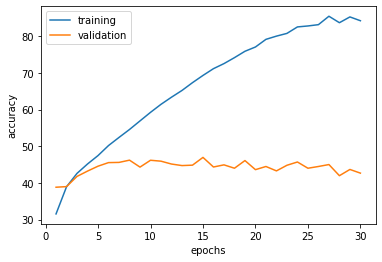

In [ ]:
myf.plot_acc(
    Base_CNN_train_acc,
    Base_CNN_val_acc, 
    epochs, 
    savefig=True, 
    name='1_BaseCNN_acc')

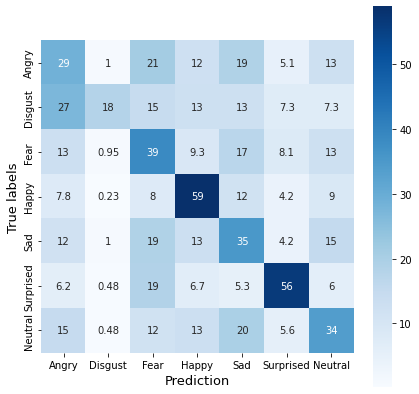

In [ ]:
myf.plot_cfmat(
    model, 
    validation_dl, 
    dict_classes, 
    savefig=True, 
    name='1_BaseCNN_cfmat')

In [ ]:
model = Base_CNN_dropout().to(dev)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

Base_CNN_dropout_train_acc, Base_CNN_dropout_val_acc = myf.fit(
    model,
    loss_fn,
    optimizer,
    epochs,
    train_dl,
    validation_dl,
    print_loss=True
)

torch.save(model.state_dict(), model_path + 'Base_CNN_dropout.pth')

Epoch 1
loss: 1.868297  [ 6336/28709]
loss: 1.790817  [12736/28709]
loss: 1.643842  [19136/28709]
loss: 1.729381  [25536/28709]
Train accuracy: 26.5% 
Val accuracy  : 33.4%
-------------------------------
Epoch 2
loss: 1.419235  [ 6336/28709]
loss: 1.713450  [12736/28709]
loss: 1.676315  [19136/28709]
loss: 1.616219  [25536/28709]
Train accuracy: 33.5% 
Val accuracy  : 36.6%
-------------------------------
Epoch 3
loss: 1.784998  [ 6336/28709]
loss: 1.524329  [12736/28709]
loss: 1.484995  [19136/28709]
loss: 1.736013  [25536/28709]
Train accuracy: 36.1% 
Val accuracy  : 38.0%
-------------------------------
Epoch 4
loss: 1.534800  [ 6336/28709]
loss: 1.422231  [12736/28709]
loss: 1.502391  [19136/28709]
loss: 1.641146  [25536/28709]
Train accuracy: 37.8% 
Val accuracy  : 39.4%
-------------------------------
Epoch 5
loss: 1.615101  [ 6336/28709]
loss: 1.440517  [12736/28709]
loss: 1.426673  [19136/28709]
loss: 1.352289  [25536/28709]
Train accuracy: 39.9% 
Val accuracy  : 41.5%
-------

In [ ]:
model = Base_CNN_dropout().to(dev)
model.load_state_dict(torch.load(model_path+'Base_CNN.pth'))
summary(model, (1, 48, 48)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 44, 44]             156
            Conv2d-2           [-1, 16, 18, 18]           2,416
           Dropout-3                 [-1, 1296]               0
            Linear-4                  [-1, 120]         155,640
           Dropout-5                  [-1, 120]               0
            Linear-6                   [-1, 84]          10,164
           Dropout-7                   [-1, 84]               0
            Linear-8                    [-1, 7]             595
Total params: 168,971
Trainable params: 168,971
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.64
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


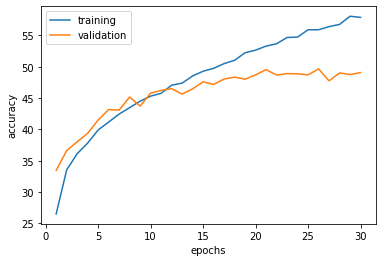

In [ ]:
myf.plot_acc(
    Base_CNN_dropout_train_acc, 
    Base_CNN_dropout_val_acc, 
    epochs, 
    savefig=True, 
    name='2_BaseCNN_do_acc')

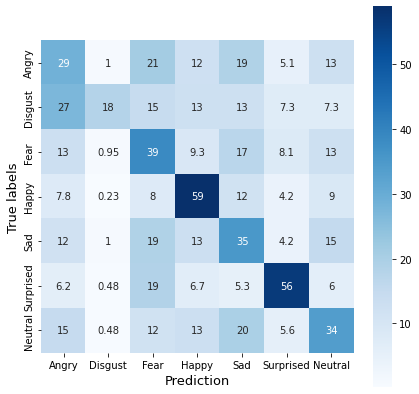

In [ ]:
myf.plot_cfmat(
    model, 
    validation_dl, 
    dict_classes, 
    savefig=True, 
    name='2_BaseCNN_do_cfmat')